In [44]:
from pyspark.sql.functions import col, sum, when, countDistinct
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 46, Finished, Available, Finished)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 47, Finished, Available, Finished)

In [46]:
dfcontratos = spark.sql("SELECT * FROM lakehouseSilver.contrato")
display(dfcontratos.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 48, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d0681970-4f11-4f7b-ab74-8ab0964ee00a)

In [47]:
dfcontratos.printSchema()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 49, Finished, Available, Finished)

root
 |-- numContrato: integer (nullable = true)
 |-- idContrato: integer (nullable = true)
 |-- idCliente: integer (nullable = true)
 |-- fechaInicio: date (nullable = true)
 |-- montoActivos: double (nullable = true)
 |-- montoSaldoAnterior: double (nullable = true)
 |-- montoNuevaCompra: double (nullable = true)
 |-- montoAbono: double (nullable = true)
 |-- moneda: string (nullable = true)
 |-- montoLeasing: double (nullable = true)
 |-- plazoOriginal: integer (nullable = true)
 |-- plazo: integer (nullable = true)
 |-- tasa: double (nullable = true)
 |-- tipoArrendamiento: string (nullable = true)
 |-- montoDeposito: double (nullable = true)
 |-- montoDepositoAbonado: double (nullable = true)
 |-- tipoCuota: string (nullable = true)
 |-- montoSinSeguro: double (nullable = true)
 |-- montoSeguroContrato: double (nullable = true)
 |-- montoMantenimiento: double (nullable = true)
 |-- montoSeguroMantenimiento: double (nullable = true)
 |-- montoReserva: double (nullable = true)
 |-- 

In [48]:
print(f"Total filas: {dfcontratos.count()}, Columnas: {len(dfcontratos.columns)}")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 50, Finished, Available, Finished)

Total filas: 1690, Columnas: 43


In [49]:
total_rows = dfcontratos.count()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 51, Finished, Available, Finished)

In [50]:
# Porcentajes nulos

nulls_info = dfcontratos.select([
    (sum(when(col(c).isNull(), 1).otherwise(0)) / total_rows).alias(c)
    for c in dfcontratos.columns
])

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 52, Finished, Available, Finished)

In [51]:
nulls_dict = nulls_info.collect()[0].asDict()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 53, Finished, Available, Finished)

In [52]:
# Columnas 100% nulas

cols_all_nulls = [c for c, perc in nulls_dict.items() if perc == 1.0]

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 54, Finished, Available, Finished)

In [53]:
# Columnas con ceros

cols_all_zeros = []

for c in dfcontratos.columns:
    # Solo aplica a columnas numéricas
    if str(dfcontratos.schema[c].dataType) in ['IntegerType', 'DoubleType', 'LongType']:
        sum_value = dfcontratos.agg(F.sum(col(c))).collect()[0][0]
        if sum_value == 0:  # Si la suma es cero, todos los valores son cero
            cols_all_zeros.append(c)

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 55, Finished, Available, Finished)

In [54]:
cols_high_nulls = [c for c, perc in nulls_dict.items() if perc > 0.7]

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 56, Finished, Available, Finished)

In [55]:
cols_to_drop = list(set(cols_all_nulls + cols_all_zeros))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 57, Finished, Available, Finished)

In [56]:
print(f"Columnas eliminadas (100% nulas o 100% ceros): {cols_to_drop}")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 58, Finished, Available, Finished)

Columnas eliminadas (100% nulas o 100% ceros): []


In [57]:
cols_to_drop2 = []

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 59, Finished, Available, Finished)

In [58]:
for c in dfcontratos.columns:
    distinct_count = dfcontratos.select(countDistinct(col(c))).collect()[0][0]
    if distinct_count <= 1:  # Solo un valor en toda la columna
        cols_to_drop2.append(c)

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 60, Finished, Available, Finished)

In [59]:
# Se eliminan columnas con un solo valor único

dfcontratos = dfcontratos.drop(*cols_to_drop2)

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 61, Finished, Available, Finished)

In [60]:
print(f"Columnas eliminadas por tener solo un valor único (incluye ceros): {cols_to_drop2}")
print(f"Nuevo número de columnas: {len(dfcontratos.columns)}")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 62, Finished, Available, Finished)

Columnas eliminadas por tener solo un valor único (incluye ceros): ['montoActivos', 'montoNuevaCompra', 'montoReserva', 'numReciboCan', 'montoSaldoCan', 'tipoAddendum']
Nuevo número de columnas: 37


In [61]:
display(dfcontratos.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 63, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 04b10058-fae3-4b97-a5f6-8b6585e8687d)

In [62]:
dfcontratos = dfcontratos.drop("idContrato", "montoAbono", "tipoCuota", "fechaAprobacion", "fechaContraActual", "estado", "idUsuario", "periodoGracia", "primeraCuota", "mesesGracia", "cancelacion", "tipoCuota")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 64, Finished, Available, Finished)

In [63]:
# Creacion de campo Churn

dfcontratos = dfcontratos.withColumn(
    "churn",
    when(col("anioCancelacion") == 1900, "No").otherwise("Si")
)

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 65, Finished, Available, Finished)

In [64]:
display(dfcontratos.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 66, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 4932c4b2-572f-42dc-9457-0d0af62189a4)

In [65]:
dfcontratos.printSchema()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 67, Finished, Available, Finished)

root
 |-- numContrato: integer (nullable = true)
 |-- idCliente: integer (nullable = true)
 |-- fechaInicio: date (nullable = true)
 |-- montoSaldoAnterior: double (nullable = true)
 |-- moneda: string (nullable = true)
 |-- montoLeasing: double (nullable = true)
 |-- plazoOriginal: integer (nullable = true)
 |-- plazo: integer (nullable = true)
 |-- tasa: double (nullable = true)
 |-- tipoArrendamiento: string (nullable = true)
 |-- montoDeposito: double (nullable = true)
 |-- montoDepositoAbonado: double (nullable = true)
 |-- montoSinSeguro: double (nullable = true)
 |-- montoSeguroContrato: double (nullable = true)
 |-- montoMantenimiento: double (nullable = true)
 |-- montoSeguroMantenimiento: double (nullable = true)
 |-- montoCompraFinal: double (nullable = true)
 |-- montoProveedor: double (nullable = true)
 |-- diaPago: integer (nullable = true)
 |-- fechaPrimerPago: date (nullable = true)
 |-- fechaUltimoPago: date (nullable = true)
 |-- fechaCancelacion: date (nullable = tru

##### Análisis de variables categóricas: distribución

In [66]:
categorical_cols = ["moneda", "tipoArrendamiento"]

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 68, Finished, Available, Finished)

In [67]:
for c in categorical_cols:
    dfcontratos.groupBy(c).count().show()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 69, Finished, Available, Finished)

+------+-----+
|moneda|count|
+------+-----+
|     1|   73|
|     2| 1617|
+------+-----+

+-----------------+-----+
|tipoArrendamiento|count|
+-----------------+-----+
|                1|  576|
|                4| 1077|
|                2|   37|
+-----------------+-----+



##### Análisis de variables numéricas: estadísticas básicas

In [68]:
numeric_cols = [
    "montoSaldoAnterior","montoLeasing","plazoOriginal","plazo","tasa","montoDeposito",
    "montoDepositoAbonado","montoSinSeguro","montoSeguroContrato","montoMantenimiento",
    "montoSeguroMantenimiento","montoCompraFinal","montoProveedor","montoValorFiscal",
    "diasGraciaPrimerPago","montoiva"
]

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 70, Finished, Available, Finished)

In [69]:
# Cardinalidad categóricas
for col_name in categorical_cols:
    dfcontratos.groupBy(col_name).count().show()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 71, Finished, Available, Finished)

+------+-----+
|moneda|count|
+------+-----+
|     1|   73|
|     2| 1617|
+------+-----+

+-----------------+-----+
|tipoArrendamiento|count|
+-----------------+-----+
|                1|  576|
|                4| 1077|
|                2|   37|
+-----------------+-----+



#####  Análisis de numéricas

In [70]:
numeric_cols = [
    "montoSaldoAnterior","montoLeasing","plazoOriginal","plazo","tasa","montoDeposito",
    "montoDepositoAbonado","montoSinSeguro","montoSeguroContrato","montoMantenimiento",
    "montoSeguroMantenimiento","montoCompraFinal","montoProveedor","montoValorFiscal",
    "diasGraciaPrimerPago","montoiva"
]

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 72, Finished, Available, Finished)

In [71]:
# dfcontratos.select(numeric_cols).describe().show()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 73, Finished, Available, Finished)

In [72]:
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 74, Finished, Available, Finished)

In [73]:
df_vector = assembler.transform(dfcontratos.na.fill(0))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 75, Finished, Available, Finished)

In [74]:
correlation = Correlation.corr(df_vector, "features").head()[0]

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 76, Finished, Available, Finished)

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 77, Finished, Available, Finished)

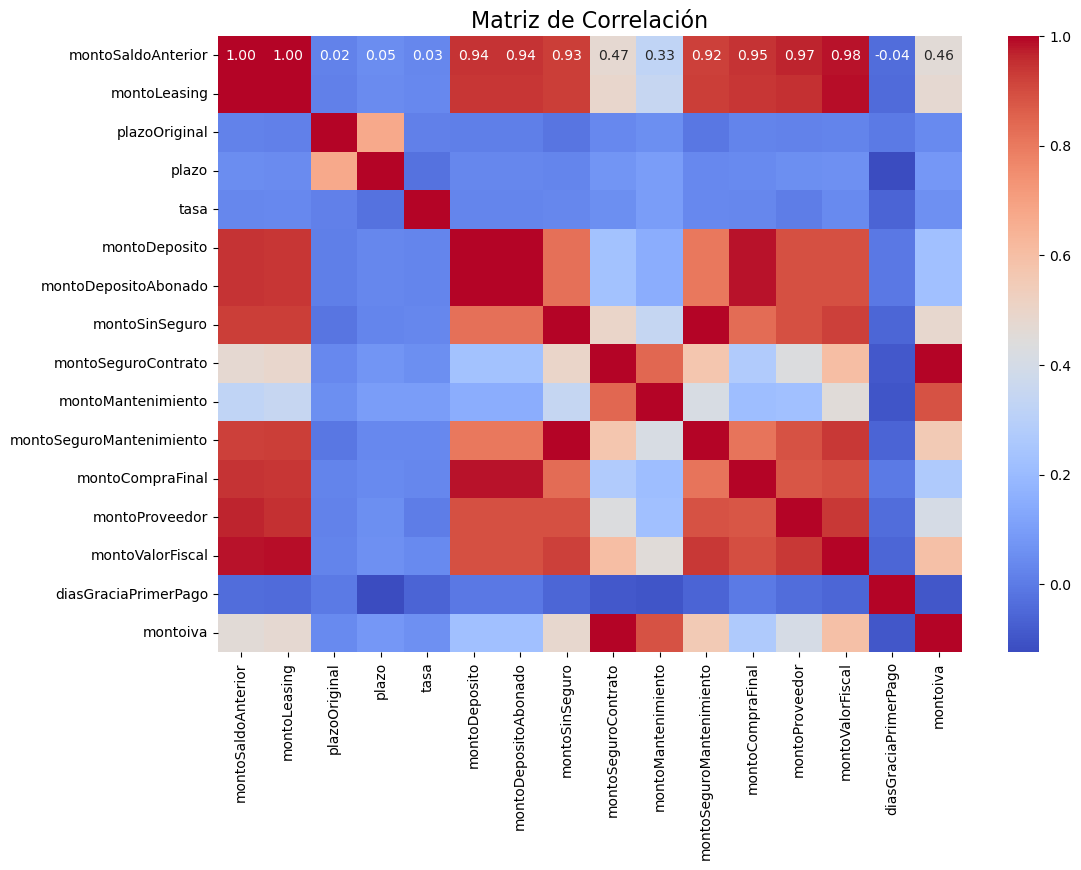

In [75]:
corr_array = correlation.toArray()

# Crear dataframe con nombres de columnas
corr_df = pd.DataFrame(corr_array, columns=numeric_cols, index=numeric_cols)

# Graficar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación", fontsize=16)
plt.show()

##### Análisis del target churn

In [76]:
dfcontratos.groupBy("churn").count().show()

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 78, Finished, Available, Finished)

+-----+-----+
|churn|count|
+-----+-----+
|   No|  914|
|   Si|  776|
+-----+-----+



### Otros datasets

In [77]:
dftipoArrendamiento = spark.sql("SELECT * FROM lakehouseSilver.tipoArrendamiento")
display(dftipoArrendamiento.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 79, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, bbc040e7-4d62-4453-9c12-67d95dd23523)

In [78]:
dfmoneda = spark.sql("SELECT * FROM lakehouseSilver.moneda")
display(dfmoneda.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 80, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, eac4d09c-153e-4445-a14c-3f609e45a295)

In [79]:
dfclientes = spark.sql("SELECT * FROM lakehouseSilver.dimensionclientesilver")
display(dfclientes.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 81, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 303bd2c7-97df-4442-9976-7c6fab03a36c)

In [80]:
dfindustria = spark.sql("SELECT * FROM lakehouseSilver.dimensionindustriasilver")
display(dfindustria.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 82, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1234add5-9530-4fe8-a655-82effd90a27d)

In [81]:
dfsegmento = spark.sql("SELECT * FROM lakehouseSilver.dimensionsegmentocomercialsilver")
display(dfsegmento.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 83, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c73d4807-81e5-4f43-91f1-d2b1bd2896d6)

In [82]:
dfvalorestrategico = spark.sql("SELECT * FROM lakehouseSilver.dimensionvalorestrategicosilver")
display(dfvalorestrategico.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 84, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 45a1a596-b2ae-42d4-825b-596d8b186832)

In [83]:
dfcanal = spark.sql("SELECT * FROM lakehouseSilver.dimensioncanalsilver")
display(dfcanal.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 85, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, eab7ca11-8bf5-4171-a7d9-6f1ebab778f0)

#### JOINs

In [107]:
# Arrendamiento en Contratos

dfContratos2 = dfcontratos.join(
    dftipoArrendamiento,
    dfcontratos["tipoArrendamiento"] == dftipoArrendamiento["idTipoArrendamiento"],
    "left"
).drop(dftipoArrendamiento["idTipoArrendamiento"]) 

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 109, Finished, Available, Finished)

In [93]:
display(dfclientes.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 95, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, e0a8bbb6-abd4-45fa-9907-26d3ae93285b)

In [92]:
display(dfcanal.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 94, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8b503ecf-720b-4849-9158-ea9c5bc8965c)

In [110]:
# Canal en Clientes

dfClientes1 = dfclientes.join(
    dfcanal,
    dfclientes["skCanal"] == dfcanal["skCanal"],
    "left"
).drop("Código", "Descripcion", "skCanal", "FechaCreacion", "EsActual")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 112, Finished, Available, Finished)

In [111]:
display(dfClientes1.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 113, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 81f93301-87e8-4928-ab40-9655f74b032f)

In [122]:
# Industria en Clientes

dfClientes2 = dfClientes1.join(
    dfindustria,
    dfClientes1["skIndustria"] == dfindustria["skIndustria"],
    "left"
).drop("Código", "skIndustria", "Descripcion", "dfindustria", "FechaCreacion", "EsActual")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 124, Finished, Available, Finished)

In [124]:
# Segmento en Clientes

dfClientes3 = dfClientes2.join(
    dfsegmento,
    dfClientes2["skSegmentoComercial"] == dfsegmento["skSegmentoComercial"],
    "left"
).drop("Código", "DescripciónBreve", "skSegmentoComercial", "FechaCreacion", "EsActual")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 126, Finished, Available, Finished)

In [126]:
# Valor en Clientes

dfClientes4 = dfClientes3.join(
    dfvalorestrategico,
    dfClientes3["skValorEstrategico"] == dfvalorestrategico["skValorEstrategico"],
    "left"
).drop("Código", "Descripción", "skValorEstrategico", "FechaCreacion", "EsActual")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 128, Finished, Available, Finished)

In [127]:
display(dfClientes4.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 129, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c3739e09-928b-48e2-8200-02a529b635cf)

In [129]:
display(dfContratos2.limit(5))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 131, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b40c0e9a-f19f-4c2a-872c-1e2f45a9484d)

In [130]:
# Clientes en Contratos

dfContratos3 = dfContratos2.join(
    dfClientes4,
    dfContratos2["idCliente"] == dfClientes4["codigoCliente"],
    "left"
).drop("skCliente", "codigoCliente", "fechaIngreso")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 132, Finished, Available, Finished)

In [132]:
display(dfContratos3.limit(7))

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 134, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 277643a7-1188-4d42-8aca-f9c6e5c4c6f4)

In [133]:
dfFinal = dfContratos3.withColumnRenamed("Sector", "Industria")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 135, Finished, Available, Finished)

In [135]:
dfFinal.write.format("delta").mode("overwrite").saveAsTable("dfContratosFinal")

StatementMeta(, 05458ce9-5a0b-4597-8671-a15dc0433e05, 137, Finished, Available, Finished)